In [1]:

import sys
import sklearn
import matplotlib
import numpy as np

In [3]:
conda install keras


Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Soorya\anaconda3

  added / updated specs:
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.2.0        |            eigen           3 KB
    absl-py-0.9.0              |           py37_0         168 KB
    astor-0.8.0                |           py37_0          47 KB
    conda-4.8.3                |           py37_0         2.8 MB
    gast-0.3.3                 |             py_0          14 KB
    grpcio-1.27.2              |   py37h351948d_0         1.2 MB
    keras-2.3.1                |                0           6 KB
    keras-applications-1.0.8 

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Using TensorFlow backend.
C:\Users\Soorya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Soorya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Soorya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Soorya\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

11493376/11490434 [==============================] - 17s 1us/step
Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [5]:

print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [6]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

C:\Users\Soorya\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


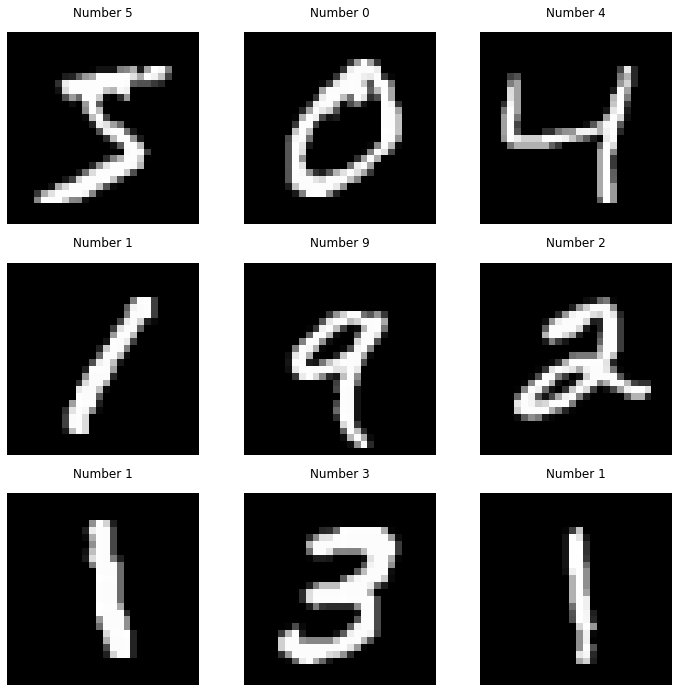

In [7]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [8]:
# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [9]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [10]:
kmeans.labels_

array([7, 8, 5, ..., 9, 6, 0])

In [11]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [13]:

cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print (predicted_labels[:20])
print (Y[:20])

[3 0 4 8 9 8 1 3 1 9 3 1 3 6 1 7 2 8 6 9]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [14]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [15]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2400908.992429772
Homogeneity: 0.42906750236323254
Accuracy: 0.5047333333333334

Number of Clusters: 16
Inertia: 2222309.724721388
Homogeneity: 0.5522332381857443
Accuracy: 0.6497333333333334

Number of Clusters: 36
Inertia: 1961613.0833381447
Homogeneity: 0.6748080576952195
Accuracy: 0.74105

Number of Clusters: 64
Inertia: 1812829.9060348659
Homogeneity: 0.7406635791068065
Accuracy: 0.8090166666666667

Number of Clusters: 144
Inertia: 1634507.2743270437
Homogeneity: 0.8077974802020188
Accuracy: 0.8709166666666667

Number of Clusters: 256
Inertia: 1519088.327013
Homogeneity: 0.8423132679815172
Accuracy: 0.8962



In [16]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))
Accuracy: 0.9007

Accuracy: 0.9002



C:\Users\Soorya\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


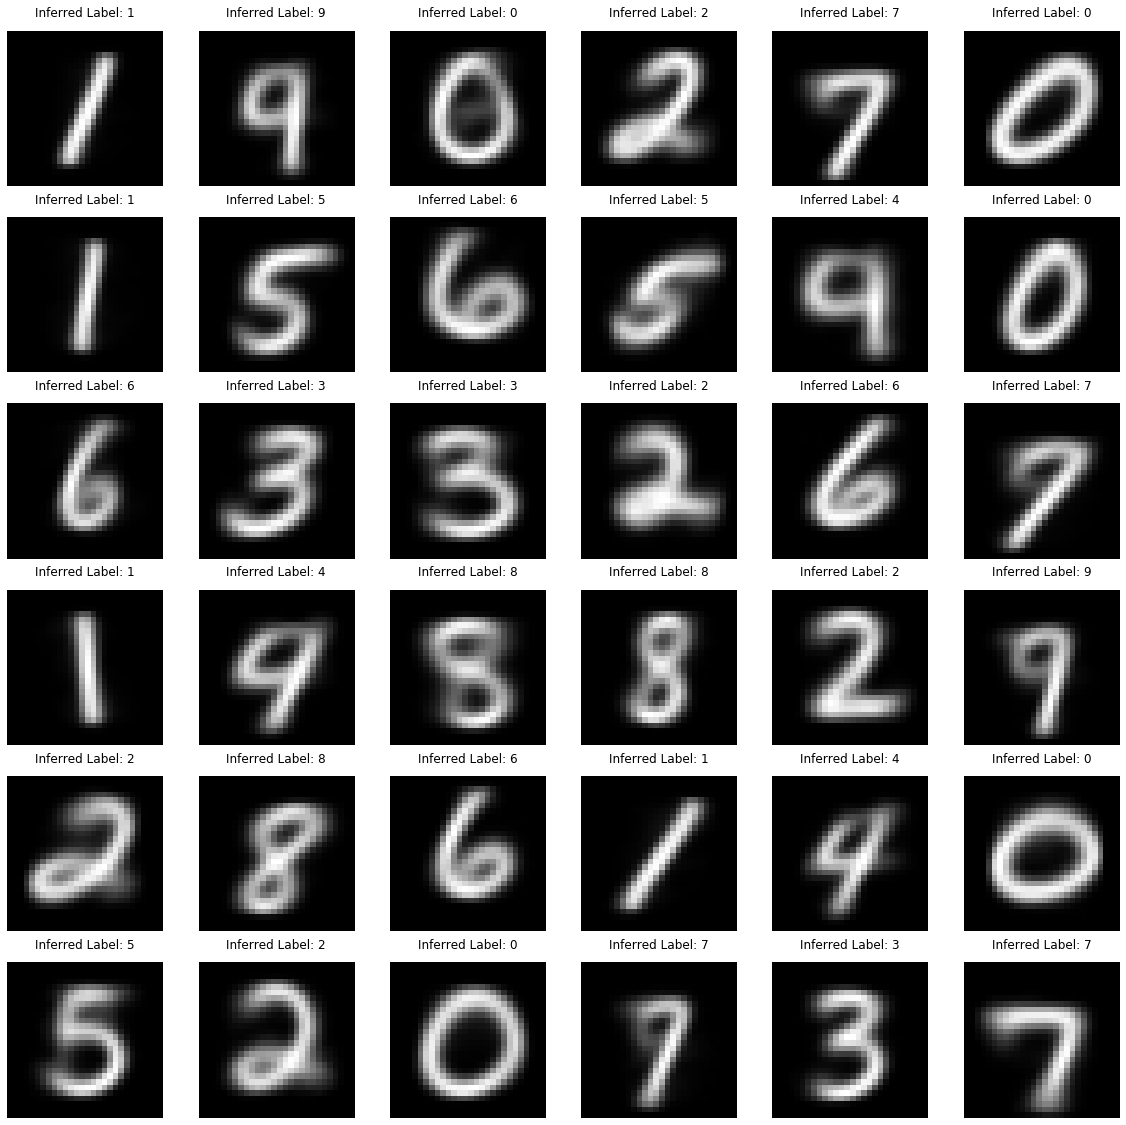

In [17]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()
